# SelfDrivingCar-P4-Advanced_LaneLines
Udacity CarND Project 4
## Advanced Lane Finding

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.  

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


# First Step: Camera Calibration

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt

# number of chessboard Corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
count = 0
plt.figure(figsize=(12, 8))
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img_cor = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.subplot(4, 5, count+1)
        plt.axis('off')
        plt.title(fname.split('/')[-1])
        plt.imshow(img_cor)
        
        write_name = './corners_found/corners'+ fname.split('/')[-1] +'.jpg'
        cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        count += 1

In [4]:
import pickle

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./output_images/calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./output_images/camera_mtx_dist.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
print("The camera is calibrated! Information is saved.")

The camera is calibrated! Information is saved.


# Second Step: Distortion Correction

## Pipeline for single images 

In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from skimage import img_as_ubyte
%matplotlib inline


def load_camera_cal_params(pickle_fname):
    """ Loads from a pickle file the camera
        distortion matrix and distances.

    Parameter:
        - pickle_fname: Pickle file name.
    Returns:
        - (mtx, dist) tuple.
    """
    with open(pickle_fname, "rb") as pf:
        data = pickle.load(pf)
        return data['mtx'], data['dist']

pickle_fname = './output_images/camera_mtx_dist.p'
mtx, dist = load_camera_cal_params(pickle_fname)

assert mtx is not None
assert mtx.shape == (3,3)
assert dist is not None

print("The camera calibration mtx and dist are loaded!")


The camera calibration mtx and dist are loaded!


## Undistortion

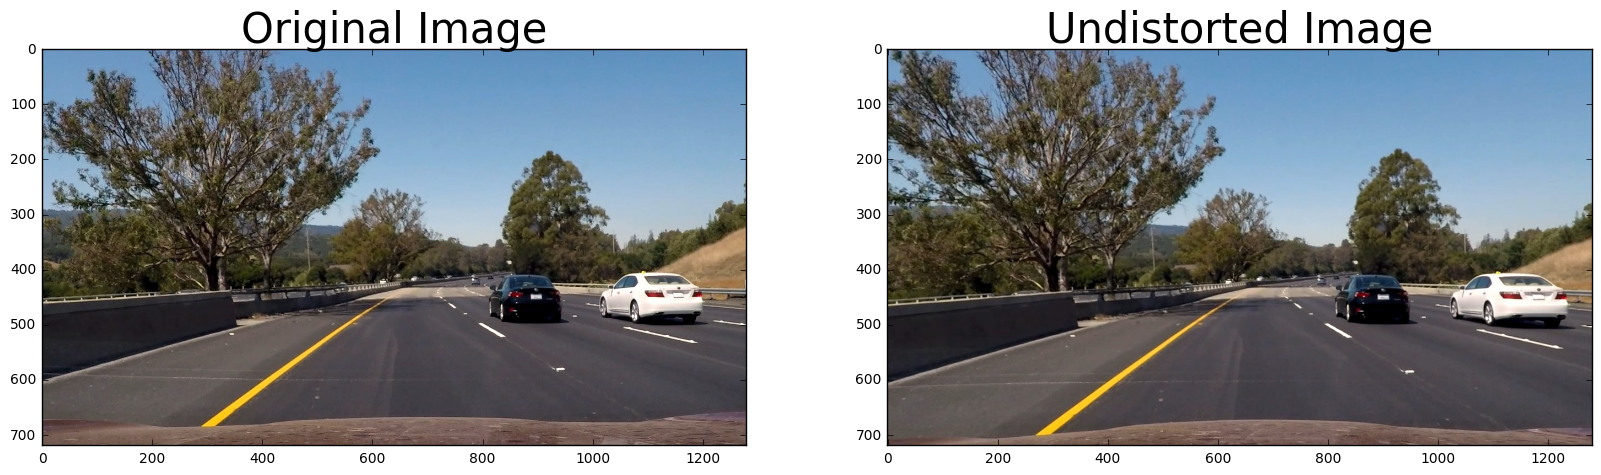

In [7]:
def pipeline_undistort(img, mtx, dist):
    """ Undistorts the input image. """
    return cv2.undistort(img, mtx, dist, None, mtx)

#img_fname = './test_images/straight_lines2.jpg'
img_fname = './test_images/test6.jpg'
#img = mpimg.imread(img_fname)
img = cv2.imread(img_fname)
img_undist = pipeline_undistort(img, mtx, dist)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # only for display reason
img_undist= cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB) # only for display reason
# Visualize undistortion

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=30)

#cv2.imwrite('./output_images/test3_undist.jpg',img_undist)


### Perspective Recovery

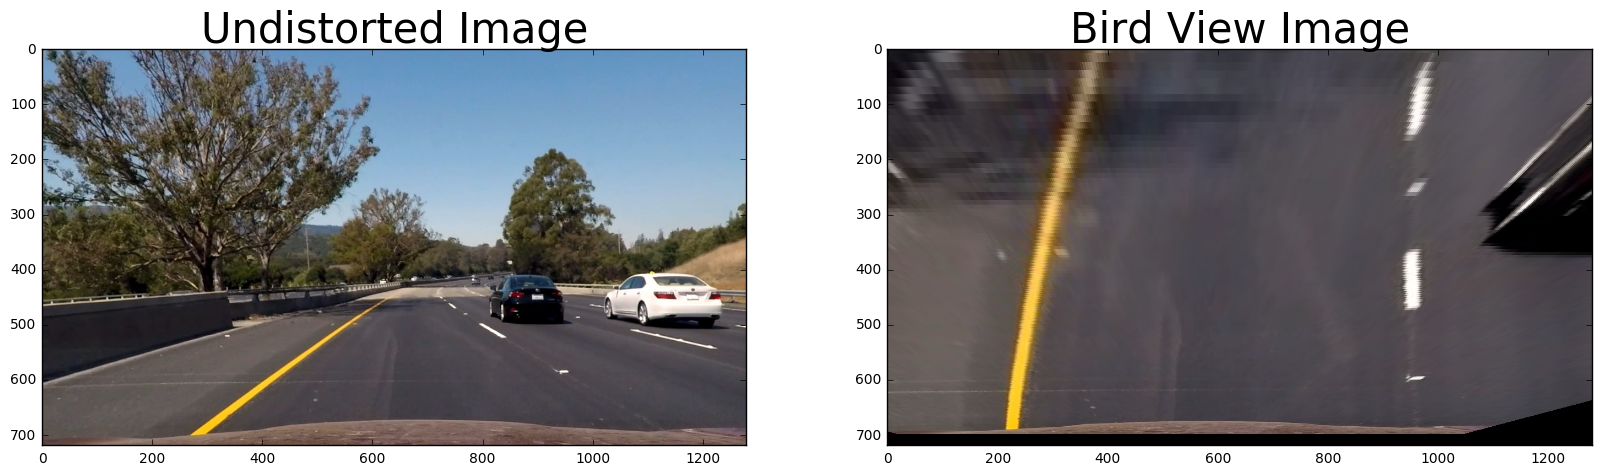

In [8]:
def birds_eye_view(img):
    """ Apply perspective transformation on input image.
        Returns: The transformed input image (Bird's Eye) as uint8 type.
    """
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    leftupperpoint  = [580,460]
    rightupperpoint = [740,460]
    leftlowerpoint  = [280,680]
    rightlowerpoint = [1150,680]

    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img_w, img_h), flags=cv2.INTER_NEAREST)
    return img_as_ubyte(warped), M

img_warped, M = birds_eye_view(img_undist)
# Visualize undistortion

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(img_warped)
ax2.set_title('Bird View Image', fontsize=30)

#cv2.imwrite('./output_images/test3_wraped.jpg',img_warped)



### Binary Output

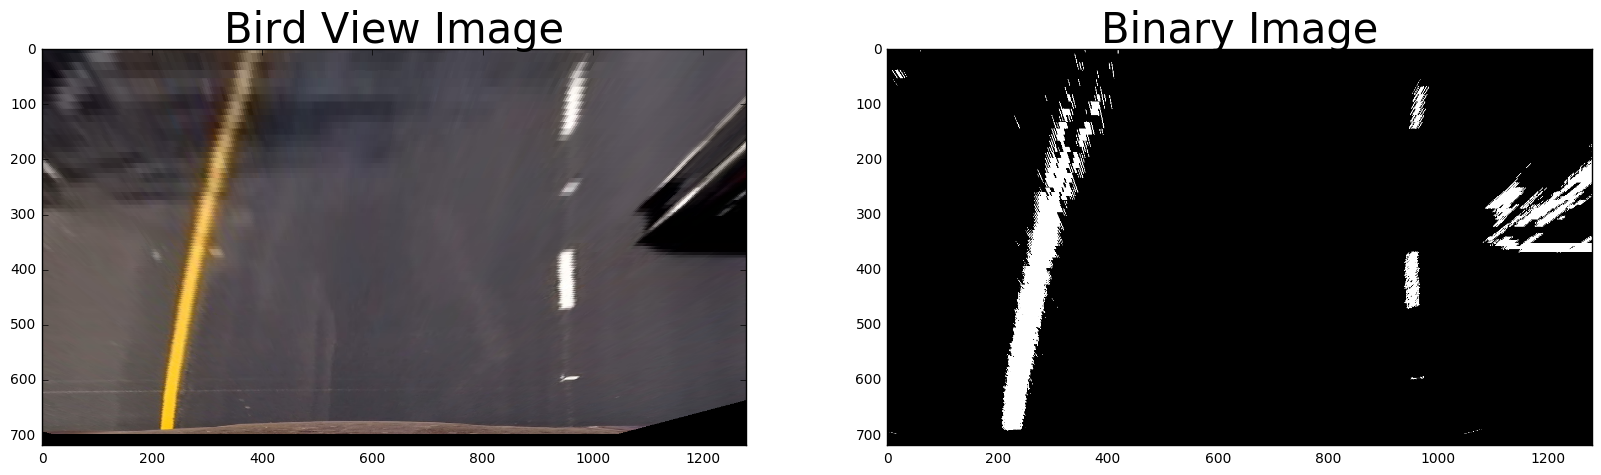

In [9]:
def binary_transform(img, sobel_kernel=3, sc_thresh=(110, 255), sx_thresh=(20, 100)):
    """ Given an input image it convert the image color space
        from RGB to HLS, tekes only the S channel and applies
        Sobel thresholding along X axis.

        Returns: a color binary image with only those pixels
        set to 1 iff the Sobel values were within the sx_thresh
        and the S channel values were within the sc_thresh.
    """
    
    img = np.copy(img)

    # Convert to HSV color space and separate the S channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Use the s_channel
    channel = s_channel
    
    # Sobel x and y
    sobel_x = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Absolute derivative in x and y
    sobel_x_abs = np.absolute(sobel_x)
    sobel_y_abs = np.absolute(sobel_y)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel_x = np.uint8(255*sobel_x_abs/np.max(sobel_x_abs))

    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel_x)
    sx_binary[(scaled_sobel_x >= sx_thresh[0]) & (scaled_sobel_x <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(channel >= sc_thresh[0]) & (channel <= sc_thresh[1])] = 1

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sx_binary), sx_binary, s_binary))
    
    #flat_binary = color_binary
    # Create a binary flat image.
    flat_binary = np.zeros_like(sx_binary)
    flat_binary[(sx_binary == 1) | (s_binary == 1)] = 1

    return flat_binary

img_binary = binary_transform(img_warped)
# Visualize undistortion

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_warped)
ax1.set_title('Bird View Image', fontsize=30)
ax2.imshow(img_binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)

#cv2.imwrite('./output_images/test3_wraped_binary.jpg',img_binary)

### Find the Lines

/Users/Hornbill/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


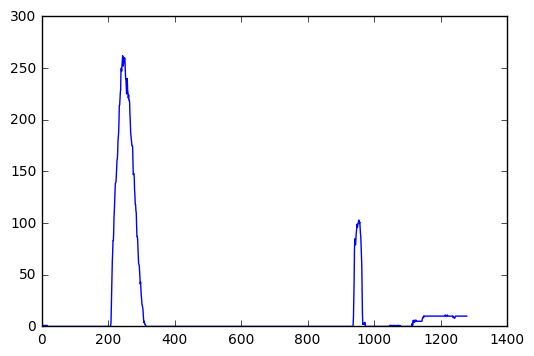

In [10]:
def plot_hist(img, axis = 0):
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    plt.plot(histogram)
    return histogram

histogram = plot_hist(img_binary)

(720, 0)

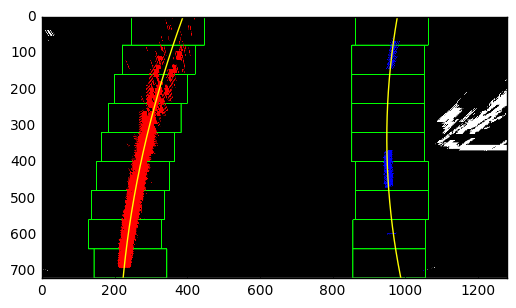

In [12]:
def findlines(binary_warped):
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((img_binary, img_binary, img_binary))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    

    ### plot the figures
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
        # Compute curve radius    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Compute car position
    m_car = binary_warped.shape[1] / 2
    m_lane = (left_fitx[0] + right_fitx[0]) / 2
    offset_right_from_center_m = (m_lane-m_car)*xm_per_pix
    
    # Now our radius of curvature is in meters
    avg_radius_meters = np.mean([left_curverad, right_curverad])
    return out_img, avg_radius_meters, offset_right_from_center_m, left_fitx, right_fitx, ploty
    
    
img_lines, r_meters, right_from_center_m, l_fit, r_fit, ploty = findlines(img_binary)
    
    
plt.imshow(img_lines)
plt.plot(l_fit, ploty, color='yellow')
plt.plot(r_fit, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


### Map Back to the Orignial Scale

In [13]:
def to_real_world_scale(image, warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result


Minv = np.linalg.inv(M)
final_output = to_real_world_scale(img, img_lines, Minv, l_fit, r_fit, ploty)

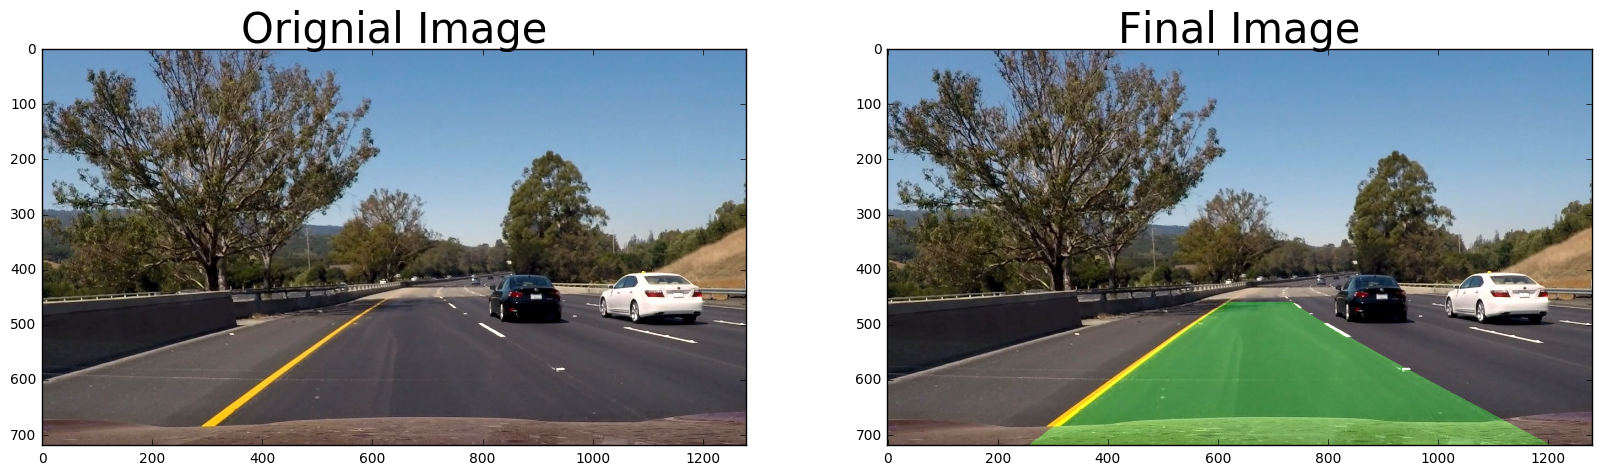

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Orignial Image', fontsize=30)
ax2.imshow(final_output)
ax2.set_title('Final Image', fontsize=30)

### Test on Videos

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [32]:
def process_image(input_image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    ksize = 9
    d_thresh  = (0.7, 1.2)
    sc_thresh=(110, 255)
    sx_thresh=(20, 100)
    
    img_undist = pipeline_undistort(input_image, mtx, dist)
    warped, M = birds_eye_view(img_undist)
    binary = binary_transform(warped, sobel_kernel=ksize, sc_thresh=sc_thresh, sx_thresh=sx_thresh )
    
    img_lines, r_meters, right_from_center_m, l_fit, r_fit, ploty = findlines(binary)
    
    
    Minv = np.linalg.inv(M)
    final_output = to_real_world_scale(input_image, img_lines, Minv, l_fit, r_fit, ploty)
    
    # Annotate image with text
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Curve Radius: {:.0f} m".format(r_meters)
    cv2.putText(final_output, text, (50,50), font, 1, (255,255,255), 2)
    text = "Offset Right from center: {:.2f} m".format(right_from_center_m)
    cv2.putText(final_output, text, (50,100), font, 1, (255,255,255), 2)
    
    #return np.hstack((final_output, img_lines))
    final_output = np.array(final_output)
    return final_output
    

<class 'numpy.ndarray'>


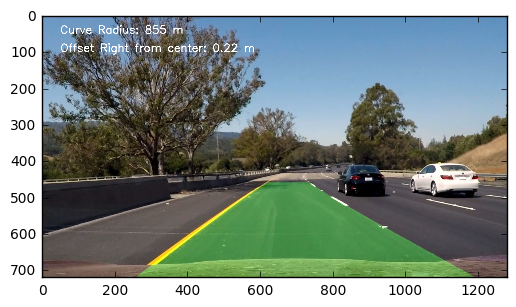

In [33]:
r = process_image(img)
print(type(r))
plt.imshow(r)
plt.show()

In [34]:
project_video_output = "./output_video/project_video_output.mp4"
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video_output, audio=False)
#import pygame
#white_clip.write_videofile(project_video_output, audio=False)
#white_clip.preview()

[MoviePy] >>>> Building video ./output_video/project_video_output.mp4
[MoviePy] Writing video ./output_video/project_video_output.mp4


100%|█████████▉| 1260/1261 [04:22<00:00,  4.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/project_video_output.mp4 

CPU times: user 4min 38s, sys: 1min 39s, total: 6min 18s
Wall time: 4min 23s


In [35]:
challenge_video_output = "./output_video/challenge_video_output.mp4"
clip2 = VideoFileClip("./challenge_video.mp4")
white_clip2 = clip2.fl_image(process_image)
%time white_clip2.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video ./output_video/challenge_video_output.mp4
[MoviePy] Writing video ./output_video/challenge_video_output.mp4


100%|██████████| 485/485 [01:41<00:00,  5.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/challenge_video_output.mp4 

CPU times: user 1min 45s, sys: 38.3 s, total: 2min 24s
Wall time: 1min 43s


In [36]:
harder_video_output = "./output_video/harder_video_output.mp4"
clip3 = VideoFileClip("./harder_challenge_video.mp4")
white_clip3 = clip3.fl_image(process_image)
%time white_clip3.write_videofile(harder_video_output, audio=False)

[MoviePy] >>>> Building video ./output_video/harder_video_output.mp4
[MoviePy] Writing video ./output_video/harder_video_output.mp4


100%|█████████▉| 1199/1200 [04:35<00:00,  4.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/harder_video_output.mp4 

CPU times: user 4min 41s, sys: 1min 34s, total: 6min 16s
Wall time: 4min 37s
